# Model comparison

With our models working reasonably well, we should start to think about comparing the different forms of the model. For example, how do we compare models with tuned normalization to those with untuned normalization? Answering these questions will allow us to determine which model components (i.e. calculations) are key for explaining the neural responses found in our data sets.

In [2]:
import numpy as np
import analyzeEval
import helper_fcns as hf
import autoreload
import sys, os
import pdb

In [3]:
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/Analysis/Functions/paul_plt_style.mplstyle');
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline

from matplotlib import rcParams, cm
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['font.style'] = 'oblique'
rcParams['font.size'] = 20;
rcParams['pdf.fonttype'] = 3 # should be 42, but there are kerning issues
rcParams['ps.fonttype'] = 3 # should be 42, but there are kerning issues

### Tuned vs Untuned

After presenting my work in an LCV meeting, Tim (Oleskiw) made some suggestions for how to compare two forms of my model. In one form, the normalization is flat over all spatial frequency, while in the other, there is a "tuning" to the normalization pool. In the language of a contrast gain control model, the stimulus energy for particular spatial frequencies is weighted more than stimulus (or contrast) energy in other portions of the frequency spectrum. In the current formulation, the weight of each filter in the normalization pool is weighted according to its position along the weighting function - a two-halved log-Gaussian with an offset. I.e., the weight of each filter is the sum of some overall offest plus the value of the weighting function evaluated at the filter's preferred frequency. 

To compare the models, we hold out one of the N conditions in the experiment (here N is 110, from 5 dispersions with 2 contrasts at 11 spatial frequency centers). Optimize each model for the N-1 conditions and evalulate both the overall loss, and the prediction error on the held out condition. Do this for all N conditions, and compare between the two models

In [10]:
lossType = 3; # 1 - sqrt, 2 - poiss, 3 - modPoiss
expInd = 1; # V1; altExp (V1); LGN
_, _, _, _, flat, weight = analyzeEval.compute_diffs(lossType, expInd=expInd, date='181129')
# diffs_loss, diffs_pred, losses, preds, flat, weight = analyzeEval.compute_diffs(lossType, expInd=expInd, date='181129')

if lossType == 1:
     lossStr = 'sqrt'
elif lossType == 2:
     lossStr = 'poiss'
elif lossType == 3:
     lossStr = 'modPoiss'

In [7]:
diffs_loss_all = diffs_loss.flatten();
diffs_pred_all = diffs_pred.flatten();

#### Analysis for when we hold out all Sfs for given con X disp

The analysis for holding out individual SFs is below

In [11]:
nCells = 59; nDisps = 5; nCons = 2;
holdNLL = dict();

NLL = np.nan * np.zeros((nCells, nDisps, nCons, 2));
holdoutNLL = np.nan * np.zeros((nCells, nDisps, nCons, 2));

for i in range(nCells):
    if i in flat:
        NLL[i, :, :, 0] = flat[i]['NLL']
        holdoutNLL[i, :, :, 0] = flat[i]['holdoutNLL']
    if i in weight:
        NLL[i, :, :, 1] = weight[i]['NLL']
        holdoutNLL[i, :, :, 1] = weight[i]['holdoutNLL']
        
diffs = dict();
diffs['NLL'] = NLL[:, :, :, 0] - NLL[:, :, :, 1]
diffs['holdoutNLL'] = holdoutNLL[:, :, :, 0] - holdoutNLL[:, :, :, 1]

dn_flattened = diffs['NLL'].flatten();
dh_flattened = diffs['holdoutNLL'].flatten();

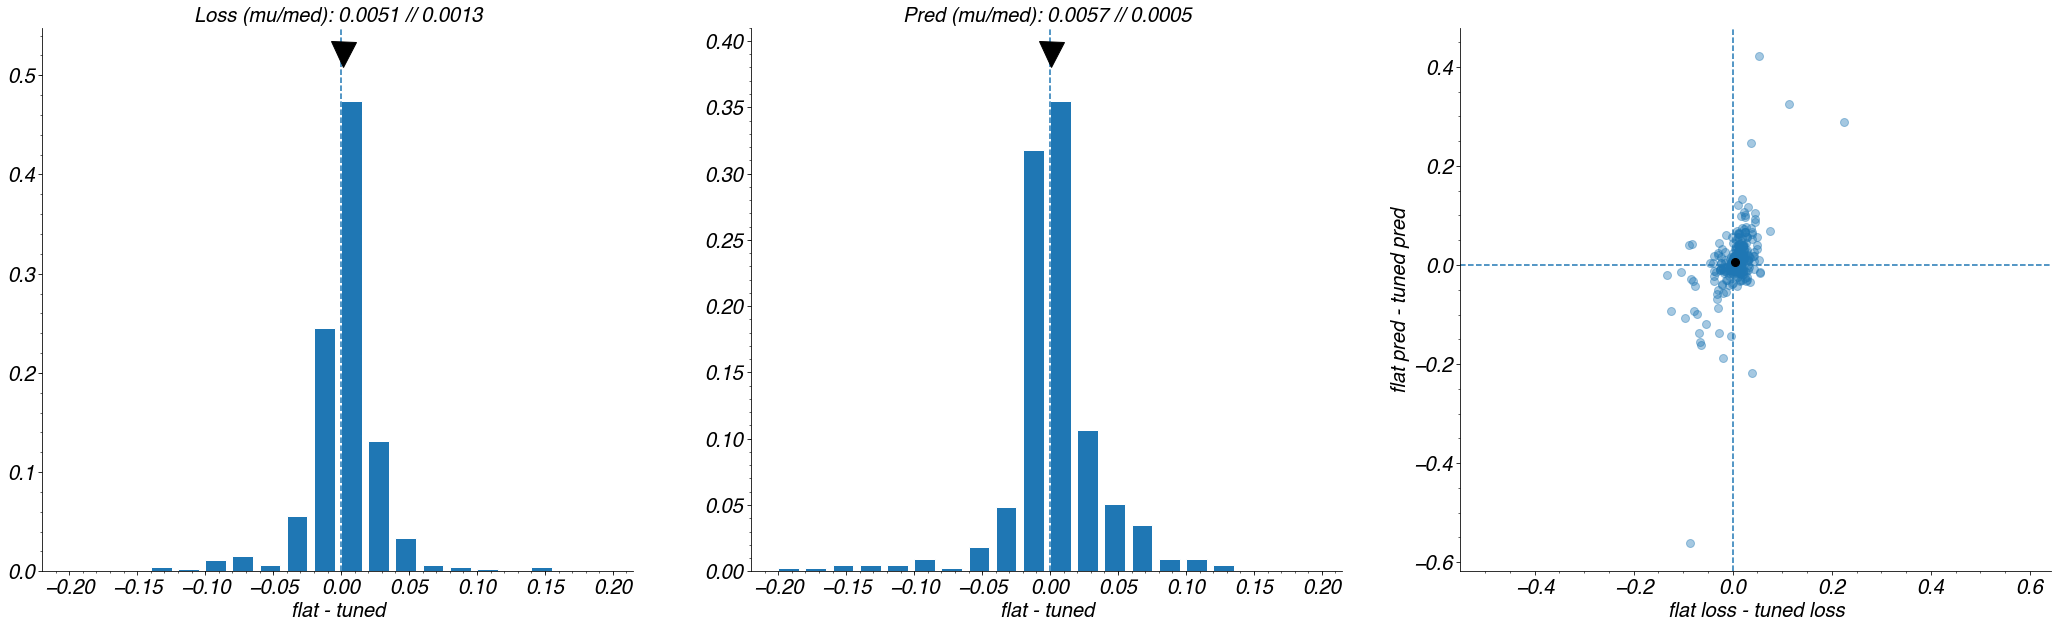

In [13]:
nRows = 1;
nCols = 3;
f, ax = plt.subplots(nRows, nCols, figsize=(12*nCols, 10*nRows))

nSteps = 21;
bins = np.linspace(-0.2, 0.2, nSteps)
width = 0.8*np.ptp(bins)/nSteps # ptp is np.max - np.min
## ALL CONDITIONS

# just loss
plt.subplot(nRows, nCols, 1)
non_nan_nll = dn_flattened[~np.isnan(dn_flattened)];
counts, _ = np.histogram(non_nan_nll, bins=bins)
counts_norm = counts/len(non_nan_nll)
plt.bar(bins[0:-1], counts_norm, width=width, align='edge')
plt.axvline(0, ls='--')
plt.plot(np.median(non_nan_nll), 1.1*np.max(counts_norm), 'v', markersize=25, color='k')
plt.xlabel('flat - tuned')
plt.title('Loss (mu/med): %.4f // %.4f' % (np.mean(non_nan_nll), np.median(non_nan_nll)))

# just prediction error
plt.subplot(nRows, nCols, 2)
non_nan_hold = dh_flattened[~np.isnan(dh_flattened)];
counts, _ = np.histogram(non_nan_hold, bins=bins)
counts_norm = counts/len(non_nan_hold)
plt.bar(bins[0:-1], counts_norm, width=width, align='edge')
plt.axvline(0, ls='--')
plt.plot(np.median(non_nan_hold), 1.1*np.max(counts_norm), 'v', markersize=25, color='k')
plt.xlabel('flat - tuned')
plt.title('Pred (mu/med): %.4f // %.4f' % (np.mean(non_nan_hold), np.median(non_nan_hold)))

# expanded
plt.subplot(nRows, nCols, 3)
plt.scatter(dn_flattened, dh_flattened, alpha=0.4);
plt.axhline(0, ls='--')
plt.axvline(0, ls='--')
plt.plot(np.nanmean(non_nan_nll), np.nanmean(non_nan_hold), 'o', color='k')
plt.xlabel('flat loss - tuned loss');
plt.ylabel('flat pred - tuned pred');
plt.axis('equal');


### Chi squared interlude

first, let's ask which version of the fit is better?


In [4]:
lossType = 4;
verSuffix = ['a', 'b', 'c'];
verK      = [0.01, 0.05, 0.1];
baseStr = 'fitListSPcns_181130';
# baseStr = 'fitListSPcns_181201';

if lossType == 1:
    lossStr = '_sqrt'
elif lossType == 2:
    lossStr = '_poiss'
elif lossType == 3:
    lossStr = '_modPoiss'
elif lossType == 4:
    lossStr = '_chiSq'


chiSq = dict();

for ver in verSuffix:
    flatNm = str(baseStr + ver + '_flat' + lossStr + '.npy')
    wghtNm = str(baseStr + ver + '_wght' + lossStr + '.npy')

    chiFlat = hf.np_smart_load('../Analysis/Structures/' + flatNm)
    chiWght = hf.np_smart_load('../Analysis/Structures/' + wghtNm)
    
    chiCurr = dict();
    
    nCells = 59;

    flat = np.nan * np.zeros((nCells, ))
    wght = np.nan * np.zeros((nCells, ))

    for i in range(nCells):
        if i in chiFlat:
            flat[i] = chiFlat[i]['NLL']
        if i in chiWght:
            wght[i] = chiWght[i]['NLL']

    chiCurr['flat'] = flat
    chiCurr['wght'] = wght
    
    chiSq[ver] = chiCurr;

In [5]:
flat_mins = np.argmin((chiSq[verSuffix[0]]['flat'], chiSq[verSuffix[1]]['flat'], chiSq[verSuffix[2]]['flat']), axis=0)
wght_mins = np.argmin((chiSq[verSuffix[0]]['wght'], chiSq[verSuffix[1]]['wght'], chiSq[verSuffix[2]]['wght']), axis=0)

In [6]:
flat_winner = np.histogram(flat_mins, bins=[0, 1, 2, 3])[0];
wght_winner = np.histogram(wght_mins, bins=[0, 1, 2, 3])[0];

In [7]:
flat_winner

array([ 6, 16, 37])

In [8]:
wght_winner

array([ 4, 18, 37])

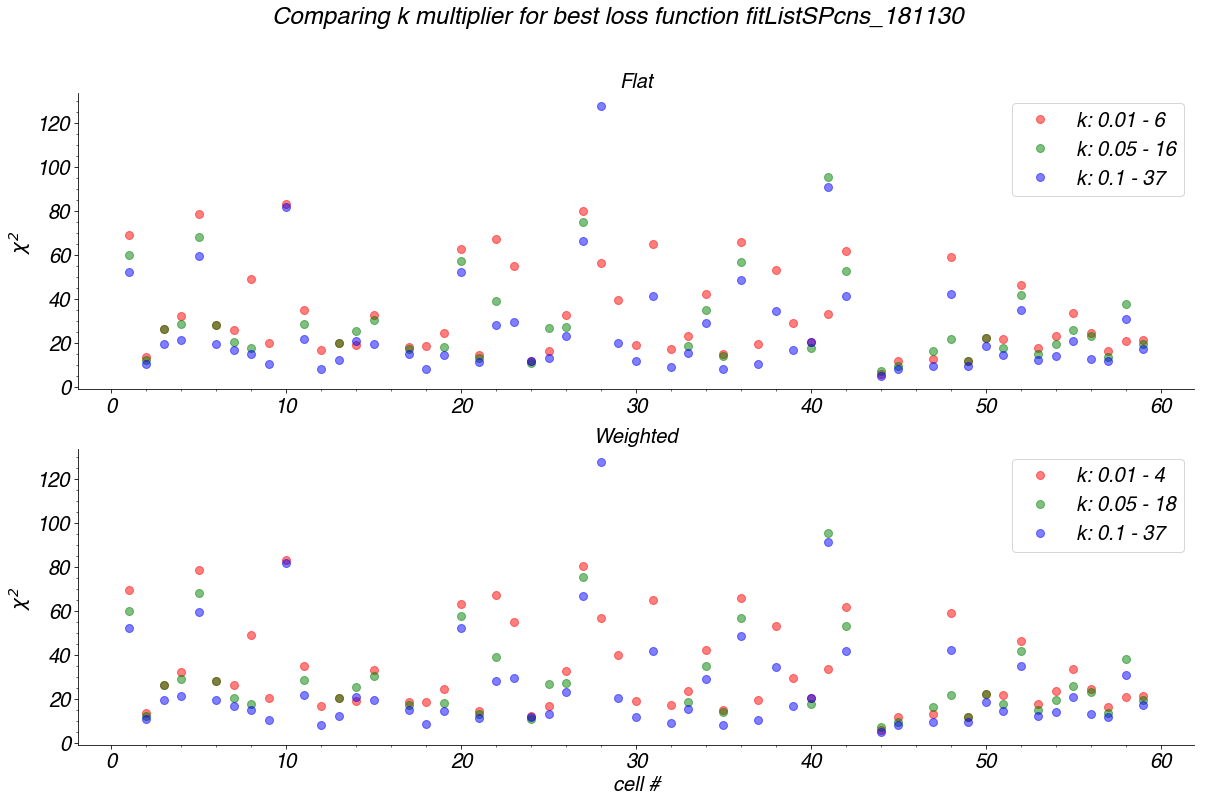

In [9]:
colors = ['r', 'g', 'b']
f, ax = plt.subplots(2, 1, figsize=(20, 12))

# flat first
verLabels = ['k: %s - %d' % (label, times) for label, times in zip(verK, flat_winner)]
[ax[0].plot(1+np.arange(nCells), chiSq[ver]['flat'], '%so' % c, alpha=0.5, label=s) for ver,c,s in zip(verSuffix, colors, verLabels)];
ax[0].set_title('Flat')
# ax[0].set_xlabel('cell #')
ax[0].set_ylabel(r'$\chi^2$')
ax[0].legend();

# flat first
verLabels = ['k: %s - %d' % (label, times) for label, times in zip(verK, wght_winner)]
[ax[1].plot(1+np.arange(nCells), chiSq[ver]['flat'], '%so' % c, alpha=0.5, label=s) for ver,c,s in zip(verSuffix, colors, verLabels)];
ax[1].set_title('Weighted')
ax[1].set_xlabel('cell #')
ax[1].set_ylabel(r'$\chi^2$')
ax[1].legend();

f.suptitle('Comparing k multiplier for best loss function %s' % baseStr);

# now save
pdf = pltSave.PdfPages(str('figures/' + 'modCompareLoss-%s%s.pdf' % (baseStr, lossStr)))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

### Now let's look at $\chi^2$ differences, distributions

In [299]:
lossType = 4;

if lossType == 1:
    lossStr = '_sqrt'
elif lossType == 2:
    lossStr = '_poiss'
elif lossType == 3:
    lossStr = '_modPoiss'
elif lossType == 4:
    lossStr = '_chiSq'

baseStr = 'fitListSPcns_181130c'
# baseStr = 'fitListSP_181202c'
flatNm = str(baseStr + '_flat' + lossStr + '.npy')
wghtNm = str(baseStr + '_wght' + lossStr + '.npy')

chiFlat = hf.np_smart_load('../Analysis/Structures/' + flatNm)
chiWght = hf.np_smart_load('../Analysis/Structures/' + wghtNm)

chiSq = dict();
nCells = 59;

flat = np.nan * np.zeros((nCells, ))
wght = np.nan * np.zeros((nCells, ))

for i in range(nCells):
    if i in chiFlat:
        flat[i] = chiFlat[i]['NLL']
    if i in chiWght:
        wght[i] = chiWght[i]['NLL']

chiSq['flat'] = flat
chiSq['wght'] = wght

In [300]:
try:
    chi_diff = chiSq['flat'] - chiSq['wght']
except:
    chi_dict = dict();
    chi_diff = [];
    chi_cell = [];
    nCells = 59;
    for i in range(nCells):
        if i in chiFlat and i in chiWght:
            chi_diff.append(chiFlat[i]['NLL'] - chiWght[i]['NLL'])
            chi_cell.append(i);
    chi_diff = np.array(chi_diff).flatten();
    chi_cell = np.array(chi_cell).flatten();
    
    chi_dict['diff'] = chi_diff;
    chi_dict['chi_cell'] = chi_cell

In [301]:
nan_rm = lambda x: x[~np.isnan(x)]

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less
/Users/paulgerald/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/Users/paulgerald/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in greater
/Users/paulgerald/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in less


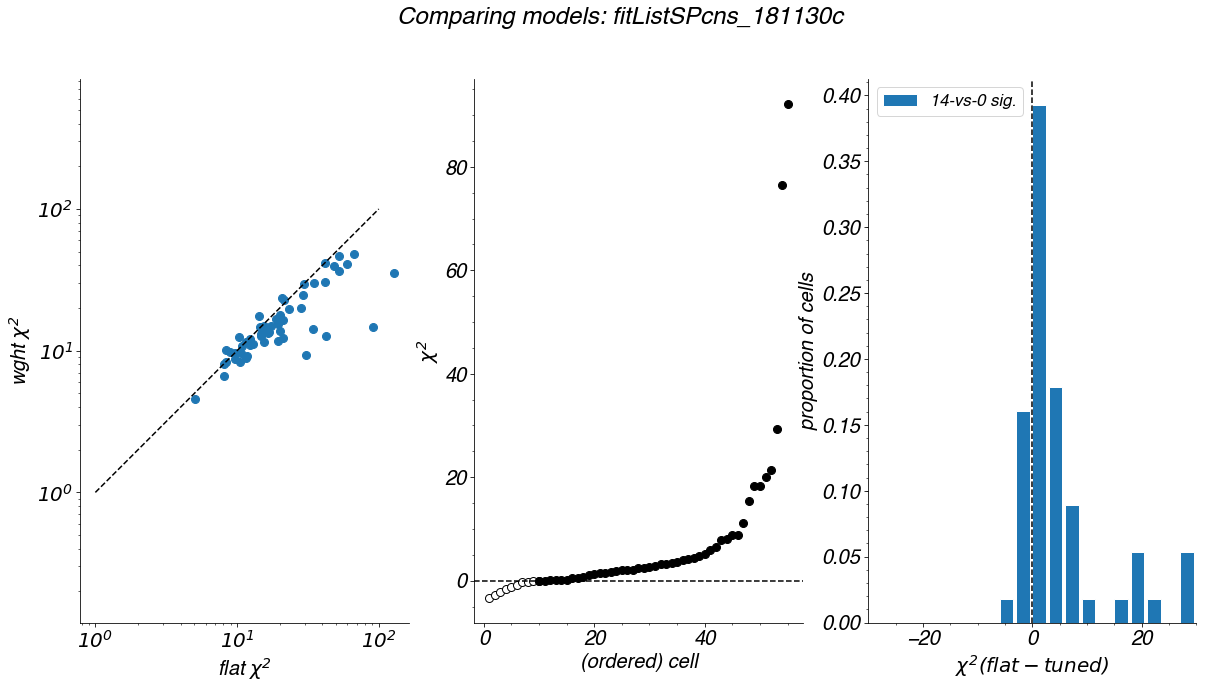

In [302]:
# chiSq = np.load('chiAnalysis.npy', encoding='latin1').item()

width=3.5;

f, ax = plt.subplots(1, 3, figsize=(20, 10), sharey=False)

# plot chi^2 values (un-normalized)
ax[0].scatter(chiSq['flat'], chiSq['wght'])
ax[0].loglog([1e-0, 1e2], [1e-0, 1e2], 'k--')
ax[0].axis('equal')
ax[0].set_xlabel(r'flat $\chi^2$');
ax[0].set_ylabel(r'wght $\chi^2$');

# plot >0 and <0 separately
lt0 = chi_diff[chi_diff<0]
gt0 = chi_diff[chi_diff>0]
ax[1].plot(1+np.arange(len(lt0)), np.sort(lt0), 'o', color='k', markerfacecolor='w')
ax[1].plot(len(lt0)+np.arange(len(gt0)), np.sort(gt0), 'o', color='k')
ax[1].axhline(0, ls='--', color='k');
ax[1].set_ylabel(r'$\chi^2$');
ax[1].set_xlabel('(ordered) cell');

# plot chi^2 values (un-normalized)
width = 2.5
bins = np.linspace(-30, 30, 21);
chi_clip = np.clip(chi_diff, bins[0], bins[-1])
counts, hist = np.histogram(nan_rm(chi_clip), bins=bins);
ax[2].axvline(0, ls='--', color='k')
sigCrit = 5.991;
ax[2].bar(hist[0:-1], counts/len(nan_rm(chi_clip)), width=width, align='edge', label='%d-vs-%d sig.' % (np.sum(chi_diff>sigCrit), np.sum(chi_diff<-sigCrit)));
ax[2].legend(fontsize='small');
ax[2].set_xlabel(r'$\chi^2 (flat - tuned)$');
ax[2].set_ylabel('proportion of cells');
ax[2].set_xlim([bins[0], bins[-1]])

# # plot normalized chi^2 differences
# width = 0.3
# chi_diff = chiSq['flat_norm'] - chiSq['wght_norm']
# bins = np.linspace(0, 5, 15);
# counts, hist = np.histogram(chi_diff, bins=bins);
# ax[2].axvline(0, ls='--', color='k')
# ax[2].bar(bins[0:-1], counts/len(chi_diff), width=width, align='edge');
# ax[2].legend();
# ax[2].set_xlabel(r'$(norm.) \chi^2 (flat - tuned)$');
# ax[2].set_ylabel('proportion of cells');

plt.suptitle('Comparing models: %s' % baseStr);

# now save
pdf = pltSave.PdfPages(str('figures/' + 'modCompare-%s%s.pdf' % (baseStr, lossStr)))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

In [304]:
print('Flat fits:', end='\n\t')
for i, j in zip(np.sort(chiSq['flat']), np.argsort(chiSq['flat'])):
    print('cell %d: %.2f' % (j+1, i), end=', ')
    
print('Weighted fits:', end='\n\t')
for i, j in zip(np.sort(chiSq['wght']), np.argsort(chiSq['wght'])):
    print('cell %d: %.2f' % (j+1, i), end=', ')



Flat fits:
	cell 44: 5.05, cell 12: 8.03, cell 45: 8.08, cell 35: 8.37, cell 18: 8.38, cell 32: 8.96, cell 47: 9.60, cell 49: 9.62, cell 9: 10.36, cell 37: 10.42, cell 2: 10.70, cell 56: 10.82, cell 21: 11.55, cell 24: 11.65, cell 30: 11.68, cell 57: 11.70, cell 13: 12.25, cell 53: 12.32, cell 25: 13.06, cell 54: 14.28, cell 19: 14.49, cell 51: 14.64, cell 17: 14.85, cell 8: 14.98, cell 40: 15.43, cell 33: 15.51, cell 39: 16.65, cell 7: 16.87, cell 59: 17.40, cell 50: 18.78, cell 15: 19.39, cell 6: 19.51, cell 3: 19.60, cell 10: 20.15, cell 29: 20.25, cell 11: 20.78, cell 14: 21.03, cell 55: 21.09, cell 4: 21.37, cell 26: 23.15, cell 22: 28.10, cell 34: 29.17, cell 23: 29.44, cell 58: 30.80, cell 38: 34.39, cell 52: 35.09, cell 31: 41.54, cell 42: 41.61, cell 48: 42.18, cell 36: 48.62, cell 20: 52.16, cell 1: 52.40, cell 5: 59.58, cell 27: 66.58, cell 41: 91.18, cell 28: 127.60, cell 43: nan, cell 46: nan, cell 16: nan, Weighted fits:
	cell 44: 4.57, cell 45: 6.63, cell 12: 8.03, cell 

In [305]:
np.sort(chi_diff)

array([-3.31287977e+00, -2.79837939e+00, -2.10815141e+00, -1.67592139e+00,
       -1.27307031e+00, -8.51125765e-01, -2.59574476e-01, -1.82603894e-01,
       -1.10906977e-02, -8.98844556e-05,  1.34361275e-02,  2.79233288e-02,
        3.33237225e-02,  7.91661659e-02,  1.22887731e-01,  2.05893871e-01,
        4.72608920e-01,  5.50210332e-01,  7.93010669e-01,  1.02864619e+00,
        1.23094754e+00,  1.44428399e+00,  1.47930168e+00,  1.66729552e+00,
        1.92879523e+00,  1.98189237e+00,  2.13596582e+00,  2.14296897e+00,
        2.51785126e+00,  2.53497609e+00,  2.55355838e+00,  2.73878549e+00,
        3.17237255e+00,  3.28190918e+00,  3.39797079e+00,  3.56839879e+00,
        3.89928393e+00,  4.09172525e+00,  4.45179247e+00,  4.68003099e+00,
        5.09612440e+00,  5.94132188e+00,  6.42260990e+00,  7.82174032e+00,
        8.10836510e+00,  8.77045926e+00,  8.81621010e+00,  1.12232059e+01,
        1.54095878e+01,  1.82044563e+01,  1.83489678e+01,  2.00560429e+01,
        2.14012496e+01,  

In [307]:
1+np.argsort(chi_diff)

array([54, 11,  9, 35,  4, 32, 31, 19, 56, 12, 18, 21, 49, 23, 30, 53, 44,
       33, 47,  2, 13, 45, 51,  8, 50, 25, 17, 37, 29, 59, 57, 24, 15,  7,
       39, 26, 40,  3, 34, 55, 52,  1, 10,  6, 22, 14, 36, 42, 20, 27,  5,
       38, 58, 48, 41, 28, 43, 46, 16])

### back to where we were

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:85: RuntimeWarning: Mean of empty slice
/Users/paulgerald/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:88: RuntimeWarning: Mean of empty slice


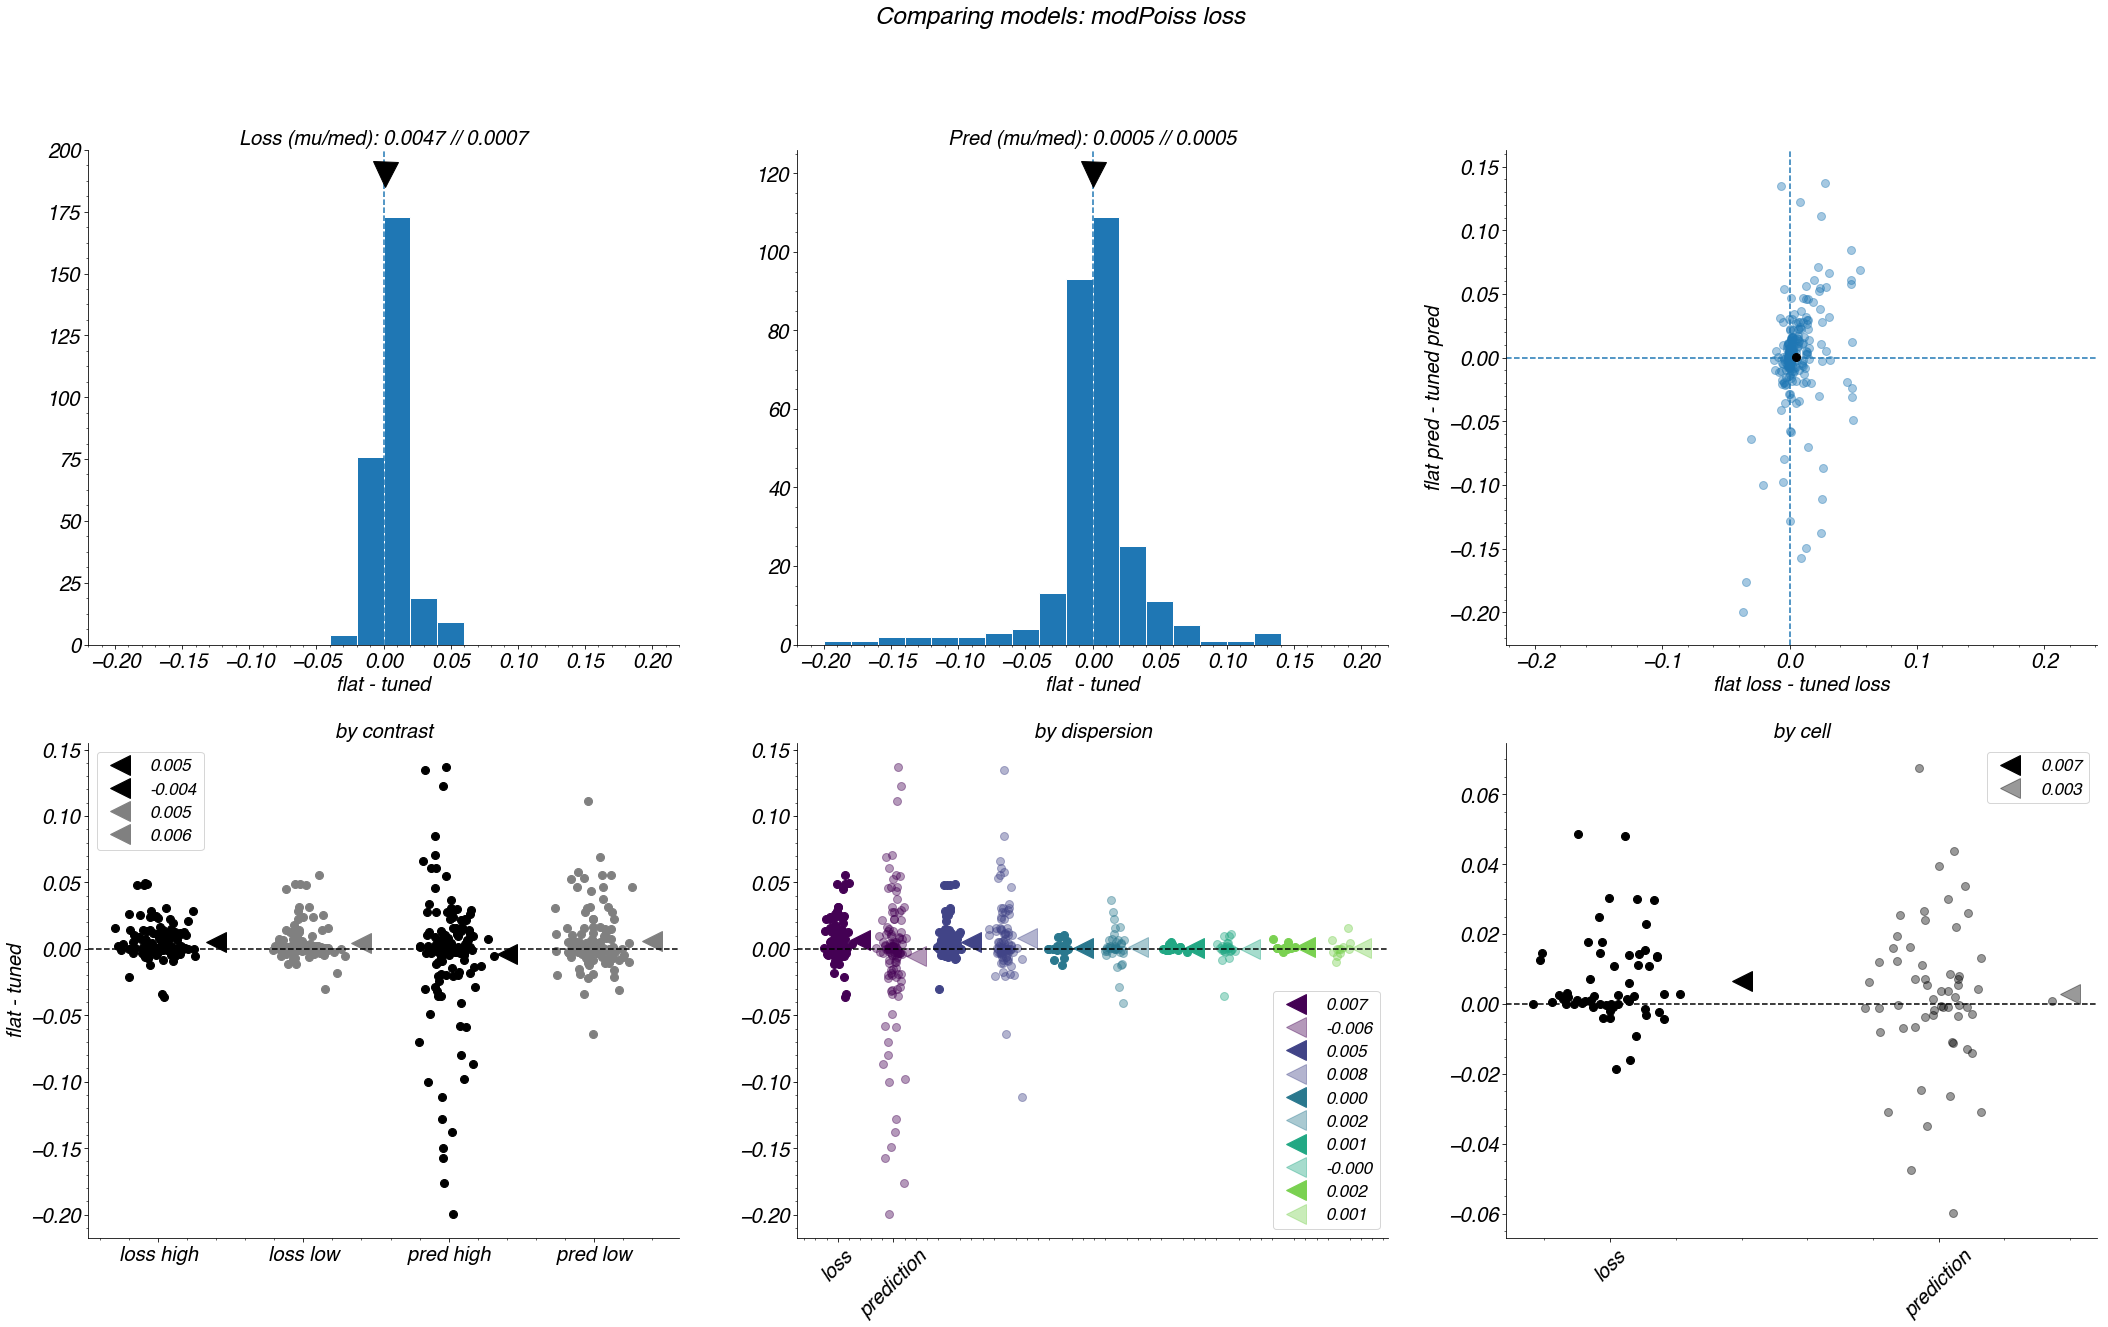

In [39]:
nRows = 2;
nCols = 3;
f, ax = plt.subplots(nRows, nCols, figsize=(12*nCols, 10*nRows))

bins = np.linspace(-0.2, 0.2, 21)

## ALL CONDITIONS

# just loss
plt.subplot(nRows, nCols, 1)
non_nan = diffs_loss_all[~np.isnan(diffs_loss_all)];
n, _, _ = plt.hist(non_nan, bins=bins)
plt.axvline(0, ls='--')
plt.plot(np.median(non_nan), 1.1*np.max(n), 'v', markersize=25, color='k')
plt.xlabel('flat - tuned')
plt.title('Loss (mu/med): %.4f // %.4f' % (np.mean(non_nan), np.median(non_nan)))

# just prediction error
plt.subplot(nRows, nCols, 2)
non_nan = diffs_pred_all[~np.isnan(diffs_pred_all)];
n, _, _ = plt.hist(diffs_pred_all[~np.isnan(diffs_pred_all)], bins=bins)
plt.axvline(0, ls='--')
plt.plot(np.median(non_nan), 1.1*np.max(n), 'v', markersize=25, color='k')
plt.xlabel('flat - tuned')
plt.title('Pred (mu/med): %.4f // %.4f' % (np.mean(non_nan), np.median(non_nan)))

# expanded
plt.subplot(nRows, nCols, 3)
plt.scatter(diffs_loss_all, diffs_pred_all, alpha=0.4);
plt.axhline(0, ls='--')
plt.axvline(0, ls='--')
plt.plot(np.nanmean(diffs_loss_all), np.nanmean(diffs_pred_all), 'o', color='k')
plt.xlabel('flat loss - tuned loss');
plt.ylabel('flat pred - tuned pred');
plt.axis('equal');

## SLICES (e.g. by cell)
# by contrast
plt.subplot(nRows, nCols, 4)
high_con = [0, 0, 0]; low_con = [0.5, 0.5, 0.5];
colors = [high_con, low_con];
mark_size = 20;

for i in range(2): # 2 contrasts

    loss_curr = diffs_loss[:, :, i].flatten()
    plt.plot(i + 0.4, np.nanmean(loss_curr), '<', markersize=mark_size, color=colors[i], label='%.3f' % np.nanmean(loss_curr))
    plt.scatter(np.random.normal(loc=i, scale=0.1, size=loss_curr.shape), loss_curr, color=colors[i])
    
    pred_curr = diffs_pred[:, :, i].flatten()
    plt.plot(i + 2.4, np.nanmean(pred_curr), '<', markersize=mark_size, color=colors[i], label='%.3f' % np.nanmean(pred_curr))
    plt.scatter(np.random.normal(loc=2 + i, scale=0.1, size=pred_curr.shape), pred_curr, color=colors[i])

plt.legend(fontsize='small');
plt.title('by contrast')
plt.axhline(0, ls='--', color='k')
plt.xticks(np.arange(4), ('loss high', 'loss low', 'pred high', 'pred low'))
plt.ylabel('flat - tuned');
# plt.axis('equal');

# by dispersion
plt.subplot(nRows, nCols, 5)
nDisps = 5;
colors = cm.viridis(np.linspace(0, 0.8, nDisps))
mark_size = 20;

for i in range(nDisps):

    loss_curr = diffs_loss[:, i, :].flatten()
    plt.plot(2*i + 0.4, np.nanmean(loss_curr), '<', markersize=mark_size, color=colors[i], label='%.3f' % np.nanmean(loss_curr))
    plt.scatter(np.random.normal(loc=2*i, scale=0.1, size=loss_curr.shape), loss_curr, color=colors[i])
    pred_curr = diffs_pred[:, i, :].flatten()
    plt.plot(2*i + 1.4, np.nanmean(pred_curr), '<', markersize=mark_size, color=colors[i], alpha=0.4, label='%.3f' % np.nanmean(pred_curr))
    plt.scatter(np.random.normal(loc=2*i+1, scale=0.1, size=pred_curr.shape), pred_curr, color=colors[i], alpha=0.4)

plt.legend(fontsize='small');
plt.title('by dispersion')
plt.axhline(0, ls='--', color='k')
plt.xticks(np.arange(2), ('loss', 'prediction'), rotation=45)

# by cell
plt.subplot(nRows, nCols, 6)
mark_size = 20;

loss_curr = np.nanmean(np.nanmean(diffs_loss, 1), 1);
plt.plot(0.4, np.nanmean(loss_curr), '<', markersize=mark_size, color=high_con, label='%.3f' % np.nanmean(loss_curr))
plt.scatter(np.random.normal(loc=0, scale=0.1, size=loss_curr.shape), loss_curr, color=high_con)
pred_curr = np.nanmean(np.nanmean(diffs_pred, 1), 1);
plt.plot(1.4, np.nanmean(pred_curr), '<', markersize=mark_size, color=high_con, alpha=0.4, label='%.3f' % np.nanmean(pred_curr))
plt.scatter(np.random.normal(loc=1, scale=0.1, size=pred_curr.shape), pred_curr, color=high_con, alpha=0.4)

plt.legend(fontsize='small');
plt.title('by cell')
plt.axhline(0, ls='--', color='k')
plt.xticks(np.arange(2), ('loss', 'prediction'), rotation=45)


plt.suptitle('Comparing models: %s loss' % lossStr);

# now save
pdf = pltSave.PdfPages(str('figures/' + 'modCompare.pdf'))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

## LGN vs. V1

Load the model fits from both LGN and V1 datasets to compare across brain areas, with a particular focus on gain control.

In [399]:
fitType  = 1; # 1 - flat; 2 - gaussian weights; 3 - adjustable c50
lossType = 3;

if fitType == 1:
    fitStr = '-flat'
elif fitType == 2:
    fitStr = '-wght'
if lossType == 1:
     lossStr = '-sqrt'
elif lossType == 2:
     lossStr = '-poiss'
elif lossType == 3:
     lossStr = '-modPoiss'

LGNbase = 'fitList_181115'
V1base  = 'fitList_181015'

LGNname = hf.fitList_name(LGNbase, fitType, lossType)
V1name  = hf.fitList_name(V1base, fitType, lossType)

fits_LGN = hf.np_smart_load(str('../LGN/analysis/structures/' + LGNname))
fits_V1  = hf.np_smart_load(str('../Analysis/Structures/' + V1name))

In [400]:
# label each LGN cell by its type
dataList_LGN = hf.np_smart_load('../LGN/analysis/structures/dataList.npy')
magno = np.where([x == 'magno' for x in dataList_LGN['unitType']])
parvo = np.where([x == 'parvo' for x in dataList_LGN['unitType']])
tbd = np.where([x == 'tbd' for x in dataList_LGN['unitType']])

lgn_type = np.zeros((len(lgnRVC), ), dtype=int);
lgn_type[magno] = 0;
lgn_type[parvo] = 1;
lgn_type[tbd] = 2;

lgn_labels = ['magno', 'parvo', 'tbd']
lgn_colors = ['k', 'r', 'b']
# lgn_colors = ['k', [0.5, 0.5, 0.5], [0.8, 0.8, 0.8]]

In [401]:
c50_ind = 2;
respExp_ind = 3;
prefSf_ind = 0;
if fitType == 2:
    normSf_ind = 8;
    normSig_ind = 9;

In [402]:
lgn = dict();
v1  = dict();

lgn['NLL'] = np.array([fits_LGN[x]['NLL'] for x in fits_LGN])
v1['NLL']  = np.array([fits_V1[x]['NLL'] for x in fits_V1])

lgn['params'] = np.array([fits_LGN[x]['params'] for x in fits_LGN])
v1['params']  = np.array([fits_V1[x]['params'] for x in fits_V1])

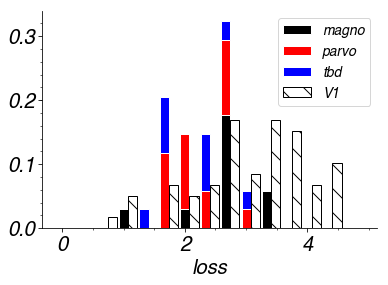

In [403]:
f, ax = plt.subplots(1, 1)
width=0.15

nLGN = len(lgn['NLL'])
NLL_type = [lgn['NLL'][magno], lgn['NLL'][parvo], lgn['NLL'][tbd]]
bins = np.linspace(0, 5, 16)
bottom = np.zeros_like(bins[0:-1]);

for i, j, k in zip(NLL_type, lgn_labels, lgn_colors):
    counts, edges = np.histogram(i, bins=bins, density=False)
    plt.bar(bins[0:-1], counts/nLGN, width=width, bottom=bottom, label=j, color=k)
    bottom = bottom+counts/nLGN;

# then, V1
nV1 = len(v1['NLL'])
counts, edges = np.histogram(v1['NLL'], bins=bins, density=False)
plt.bar(bins[0:-1]+width, counts/nV1, width=width, label='V1', edgecolor='k', color='w', hatch='\\');
plt.xlabel('loss');
plt.legend(fontsize='x-small');

# now save
pdf = pltSave.PdfPages(str('figures/' + 'modCompare-loss%s%s.pdf' % (lossStr, fitStr)))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

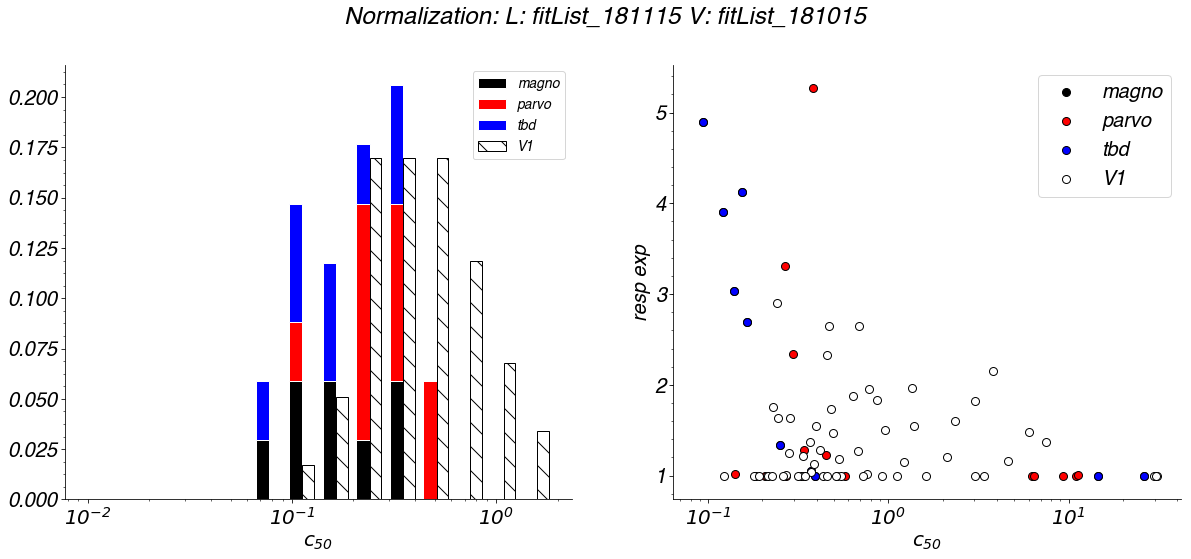

In [404]:
nRow = 1; nCol = 2;
f, ax = plt.subplots(nRow, nCol, figsize=(10*nCol, 8*nRow))

## distr. of c50
plt.subplot(nRow, nCol, 1);
wMult=0.35

nLGN = len(lgn['NLL'])
c50_lgn = np.array([np.power(10, x[c50_ind]) for x in lgn['params']])
c50_type = [c50_lgn[magno], c50_lgn[parvo], c50_lgn[magno]]

bins = np.geomspace(0.01, 2, 15)
bottom = np.zeros_like(bins[0:-1]);
plt.xscale('log')

for i, j, k in zip(c50_type, lgn_labels, lgn_colors):
    counts, edges = np.histogram(i, bins=bins, density=False)
    plt.bar(bins[0:-1], counts/nLGN, bottom=bottom, label=j, color=k, width=wMult*np.diff(bins), align='edge')
    bottom = bottom+counts/nLGN;

# then, V1
nV1 = len(v1['NLL'])
c50_v1  = [np.power(10, x[c50_ind]) for x in v1['params']]
counts, edges = np.histogram(c50_v1, bins=bins, density=False)
plt.bar(bins[0:-1]+wMult*np.diff(bins), counts/nV1, label='V1', edgecolor='k', color='w', hatch='\\', width=wMult*np.diff(bins), align='edge');

plt.xlabel(r'$c_{50}$');
plt.legend(fontsize='x-small');


## c50 vs. respExp
plt.subplot(nRow, nCol, 2);
c50_lgn = np.array([np.power(10, x[c50_ind]) for x in lgn['params']])
respExp_lgn = np.array([x[respExp_ind] for x in lgn['params']])

c50_type = [c50_lgn[magno], c50_lgn[parvo], c50_lgn[magno]]
respExp_type = [respExp_lgn[magno], respExp_lgn[parvo], respExp_lgn[magno]]

c50_v1  = [np.power(10, x[c50_ind]) for x in v1['params']]
respExp_v1  = [x[respExp_ind] for x in v1['params']]


for i, j, k, l in zip(c50_type, respExp_type, lgn_labels, lgn_colors):
    plt.scatter(i, j, label=k, color=l, edgecolors='k')

plt.scatter(c50_v1, respExp_v1, label='V1', edgecolors='k', color='w')

plt.xscale('log')
plt.xlabel(r'$c_{50}$');
plt.ylabel('resp exp');
plt.legend();

plt.suptitle('Normalization: L: %s V: %s' % (LGNbase, V1base));

pdf = pltSave.PdfPages(str('figures/' + 'modCompare-norm1%s%s.pdf' % (lossStr, fitStr)))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

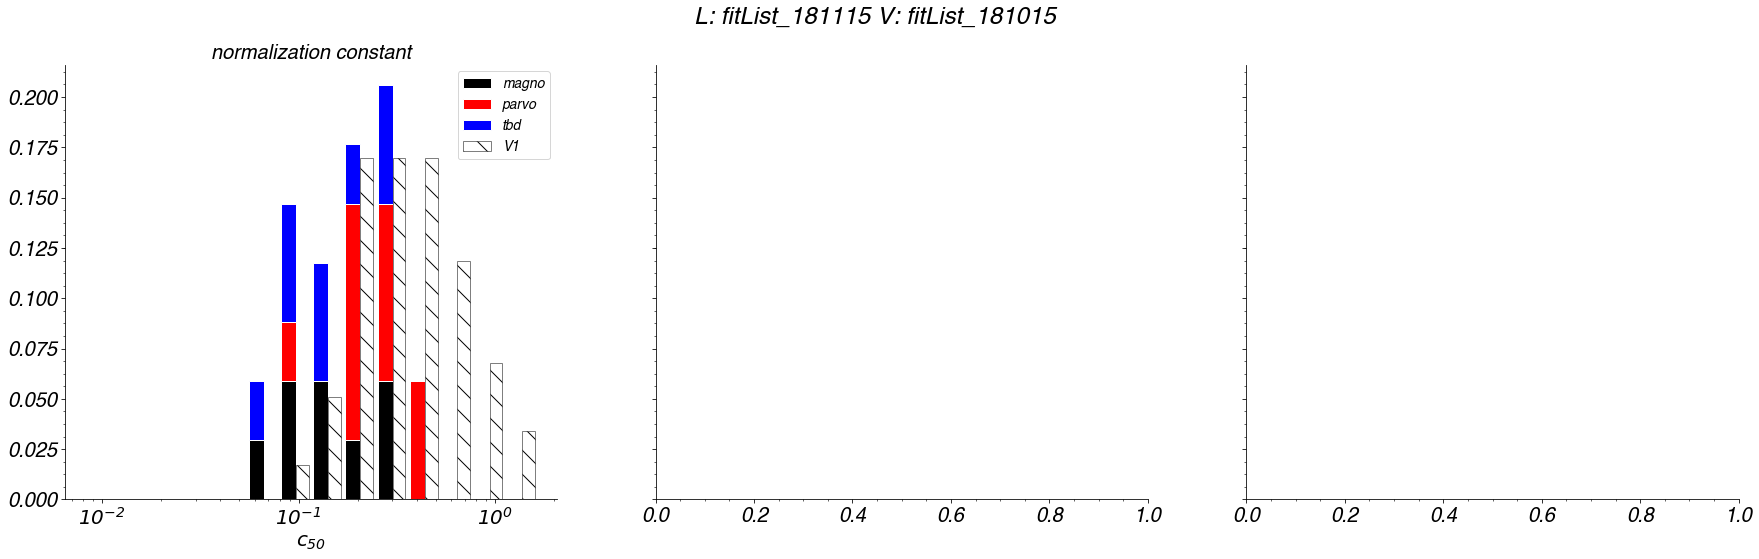

In [405]:
# normalization?
nRow = 1; nCol = 3;
f, ax = plt.subplots(nRow, nCol, figsize=(10*nCol, 8*nRow), sharey=True)

# first, c50 distribution (again)
wMult=0.35
nLGN = len(lgn['NLL'])
c50_lgn = np.array([np.power(10, x[c50_ind]) for x in lgn['params']])
c50_type = [c50_lgn[magno], c50_lgn[parvo], c50_lgn[magno]]

bins = np.geomspace(0.01, 2, 15)
bottom = np.zeros_like(bins[0:-1]);
ax[0].set_xscale('log')

for i, j, k in zip(c50_type, lgn_labels, lgn_colors):
    counts, edges = np.histogram(i, bins=bins, density=False)
    ax[0].bar(bins[0:-1]-wMult*np.diff(bins)/2, counts/nLGN, bottom=bottom, label=j, color=k, width=wMult*np.diff(bins), align='center')
    bottom = bottom+counts/nLGN;

# then, V1
nV1 = len(v1['NLL'])
c50_v1  = [np.power(10, x[c50_ind]) for x in v1['params']]
counts, edges = np.histogram(c50_v1, bins=bins, density=False)
ax[0].bar(bins[0:-1]+wMult*np.diff(bins)/2, counts/nV1, alpha=0.5, label='V1', edgecolor='k', color='w', hatch='\\', width=wMult*np.diff(bins), align='center');

ax[0].set_xlabel(r'$c_{50}$');
ax[0].set_title('normalization constant')
ax[0].legend(fontsize='x-small');

if fitType == 2:

    # what is the peak of the normalization pool relative to the filter?
    width = 0.2;
    bins = np.linspace(-4, 4, 15)
    lgn_shifts = np.array([np.log2(np.divide(np.exp(x[normSf_ind]), x[prefSf_ind])) for x in lgn['params']])
    shits_type = [lgn_shifts[magno], lgn_shifts[parvo], lgn_shifts[magno]]

    bottom = np.zeros_like(bins[0:-1]);
    for i, j, k in zip(shits_type, lgn_labels, lgn_colors):
        counts, edges = np.histogram(i, bins=bins, density=False)
        ax[1].bar(bins[0:-1]-width/2, counts/nLGN, bottom=bottom, label=j, color=k, width=width, align='edge')
        bottom = bottom+counts/nLGN;
    
    v1_shifts = np.array([np.log2(np.divide(np.exp(x[normSf_ind]), x[prefSf_ind])) for x in v1['params']])
    counts, edges = np.histogram(v1_shifts, bins=bins, density=False)
    ax[1].bar(bins[0:-1]+width/2, counts/nV1, edgecolor='k', color='w', hatch='\\', width=width, align='edge', label='V1')
    ax[1].set_xlabel(r'$mu$ ratio (log)');
    ax[1].set_title('Norm peak shift')
    ax[1].legend();

    # what is the std. (breadth) of the normalization pool?
    width = 0.05;
    bins = np.linspace(0, 2, 11)
    
    normSig_lgn = np.array([x[normSig_ind] for x in lgn['params']])
    normSig_type = [normSig_lgn[magno], normSig_lgn[parvo], normSig_lgn[tbd]]
    
    bottom = np.zeros_like(bins[0:-1]);
    for i, j, k in zip(normSig_type, lgn_labels, lgn_colors):
        counts, edges = np.histogram(i, bins=bins, density=False)
        ax[2].bar(bins[0:-1]-width/2, counts/nLGN, bottom=bottom, label=j, color=k, width=width, align='edge')
        bottom = bottom+counts/nLGN;

    normSig_v1 = [x[normSig_ind] for x in v1['params']]
    counts, edges = np.histogram(normSig_v1, bins=bins, density=False)
    ax[2].bar(bins[0:-1]+width/2, counts/nV1, edgecolor='k', color='w', hatch='\\', width=width, align='edge', label='V1')
    
    ax[2].set_xlabel(r'$\sigma$');
    ax[2].set_title('Norm std')
    ax[2].legend();
    
f.suptitle('L: %s V: %s' % (LGNbase, V1base))
    
# now save
pdf = pltSave.PdfPages(str('figures/' + 'modCompare-norm%s%s.pdf' % (lossStr, fitStr)))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

### RVCs

Let's compare simulated RVCs (simulated from model fits to each cell) in the LGN and in V1.

In [406]:
lgnRVC = np.load('rvcLGN_181115_wght_modPoiss.npy');
v1RVC  = np.load('rvcV1_181015_wght_modPoiss.npy');

rvcs = np.geomspace(0.01, 1, 11);

In [407]:
from scipy.stats.mstats import gmean

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:314: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


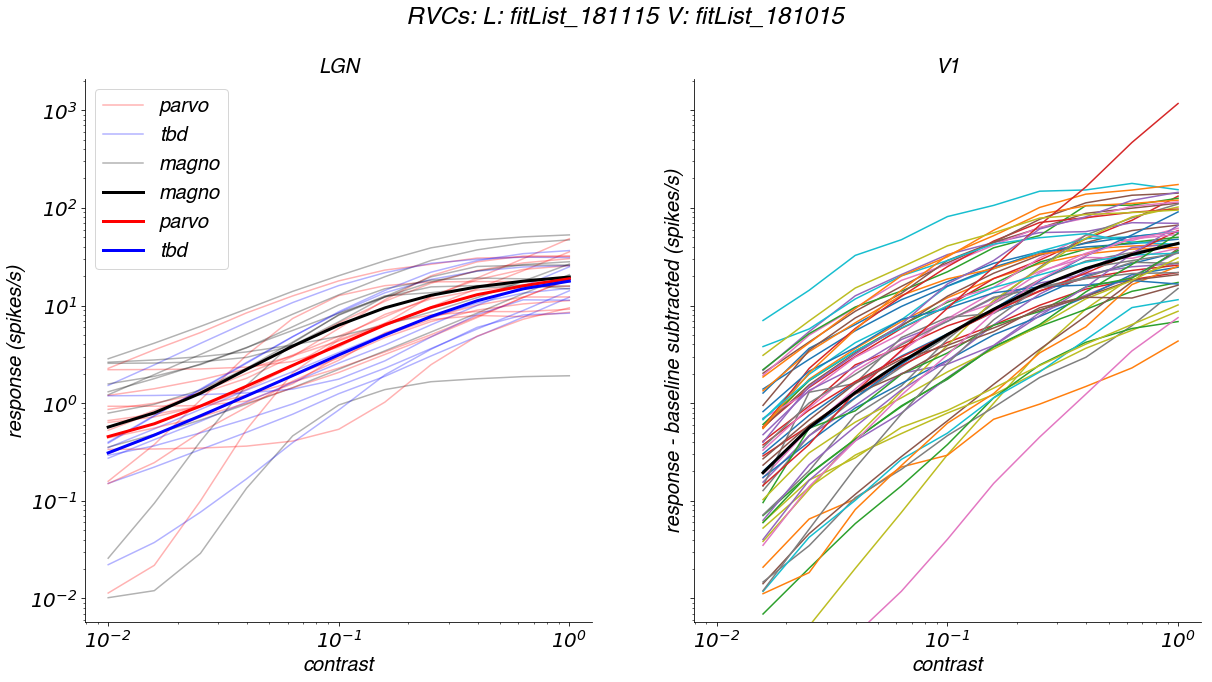

In [408]:
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20, 10))

ax[0].set_title('LGN');
ax[0].set_xlabel('contrast')
ax[0].set_ylabel('response (spikes/s)')
for i in range(len(lgnRVC)):
    curr_type = lgn_type[i]
    if np.where(lgn_type==curr_type)[0][0] == i:
        ax[0].loglog(rvcs, lgnRVC[i, :], color=lgn_colors[lgn_type[i]], label=labels[curr_type], alpha=0.3)
    else:
        ax[0].loglog(rvcs, lgnRVC[i, :], color=lgn_colors[lgn_type[i]], alpha=0.3)
for i, j, k in zip([magno, parvo, tbd], lgn_colors, lgn_labels):
    ax[0].loglog(rvcs, gmean(lgnRVC[i, :], axis=1)[0], color=j, label=k, linewidth=3)
ax[0].legend()


    
ax[1].set_title('V1');
ax[1].set_xlabel('contrast')
ax[1].set_ylabel('response - baseline subtracted (spikes/s)')
for i in range(len(v1RVC)):
    ax[1].loglog(rvcs, v1RVC[i, :]-v1RVC[i, 0])
to_sub = np.reshape(np.repeat(v1RVC[:, 0], 11), v1RVC.shape);
ax[1].loglog(rvcs, gmean(v1RVC-to_sub, axis=0), color='k', linewidth=3)

plt.suptitle('RVCs: L: %s V: %s' % (LGNbase, V1base));
    
# now save
pdf = pltSave.PdfPages(str('figures/' + 'rvcs%s%s.pdf' % (lossStr, fitStr)))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

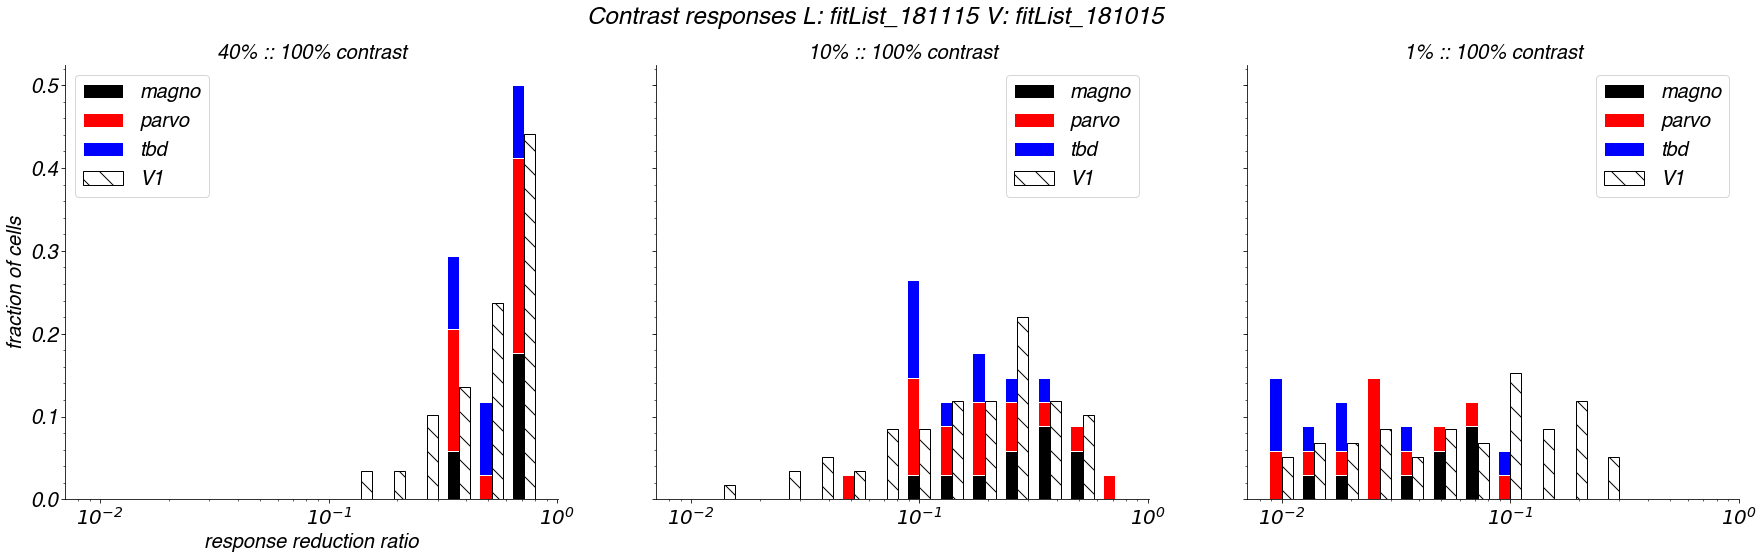

In [409]:
rvcInds = [8, 5, 0];
wMult = 0.3;

nplots = len(rvcInds);

f, ax = plt.subplots(1, nplots, figsize=(nplots*10, 8), sharey=True)

binz = np.geomspace(0.01, 1, 15)
for rvc_i, j in zip(rvcInds, range(nplots)):
    ratLGN = np.divide(lgnRVC[:, rvc_i], lgnRVC[:, -1])

    rat_type = [ratLGN[magno], ratLGN[parvo], ratLGN[tbd]];
    
    bottom = np.zeros_like(binz[0:-1])
    for ii, jj, kk in zip(rat_type, lgn_labels, lgn_colors):
        counts, edges = np.histogram(ii, bins=binz, density=False)
        ax[j].bar(binz[0:-1]-wMult*np.diff(binz)/2, counts/nLGN, bottom=bottom, label=jj, color=kk, width=wMult*np.diff(binz), align='center')
        bottom = bottom+counts/nLGN;

    ratV1  = np.divide(v1RVC[:, rvc_i], v1RVC[:, -1])
    counts, edges = np.histogram(ratV1, bins=binz, density=False)
    ax[j].bar(binz[0:-1]+wMult*np.diff(binz)/2, counts/nV1, edgecolor='k', color='w', hatch='\\', width=wMult*np.diff(binz), align='center', label='V1')
        
    ax[j].set_xscale('log')
    ax[j].set_title('%.0f%% :: 100%% contrast' % (100*rvcs[rvc_i]));
    ax[j].legend();
    
    if j == 0:
        ax[j].set_xlabel('response reduction ratio')
        ax[j].set_ylabel('fraction of cells')

plt.suptitle('Contrast responses L: %s V: %s' % (LGNbase, V1base));

# now save
pdf = pltSave.PdfPages(str('figures/' + 'rvcs-reduction%s%s.pdf' % (lossStr, fitStr)))
pdf.savefig(f, bbox_inches="tight")
pdf.close()